In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gnninterpreter import *

In [3]:
import matplotlib.pyplot as plt
import torch
from torch import nn

# Cyclicity

In [5]:
dataset = CyclicityDataset(seed=12345)

data: Data(x=[96, 1], edge_index=[2, 192], edge_attr=[192, 2], y=[1], G=Graph with 96 nodes and 96 edges)
class: red_cyclic


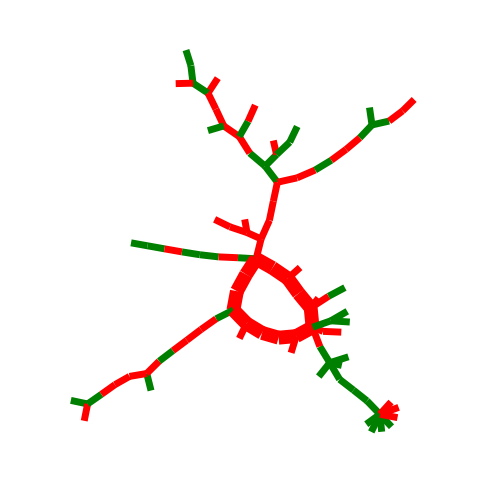

In [6]:
dataset.show(7)

In [7]:
model = NNConvClassifier(node_features=len(dataset.NODE_CLS),
                         edge_features=len(dataset.EDGE_CLS),
                         num_classes=len(dataset.GRAPH_CLS),
                         hidden_channels=32)

In [8]:
model.load_state_dict(torch.load('ckpts/cyclicity.pt'))

<All keys matched successfully>

In [108]:
dataset.evaluate_model(model)

{'red_cyclic': 0.9783830046653748,
 'green_cyclic': 0.9642987251281738,
 'acyclic': 0.9724578261375427}

In [9]:
mean_embeds = dataset.mean_embeddings(model)

In [11]:
trainer = {}
sampler = {}

# Red Cyclic

In [104]:
classes = 0
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_edge_cls=len(dataset.EDGE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=False,
                                    learn_edge_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingCriterion(classes=[classes], beta=2), mode="maximize", weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=1),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    # NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    # NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    NormPenalty(lambda: s.eta, order=1, weight=0), # L1 penalty on eta
    NormPenalty(lambda: s.eta, order=2, weight=0), # L2 penalty on eta
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=1), # Budget penalty on theta, encourage sparsity
    # CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=5), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=dataset,
                           k_samples=16)

In [105]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9
    
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 15
    ])

In [106]:
trainer[0].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=15 m=15
logits=[11.119600296020508, -5.145230770111084, 2.5520236492156982]
probs=[0.9998098015785217, 8.63357811908827e-08, 0.0001901368232211098]


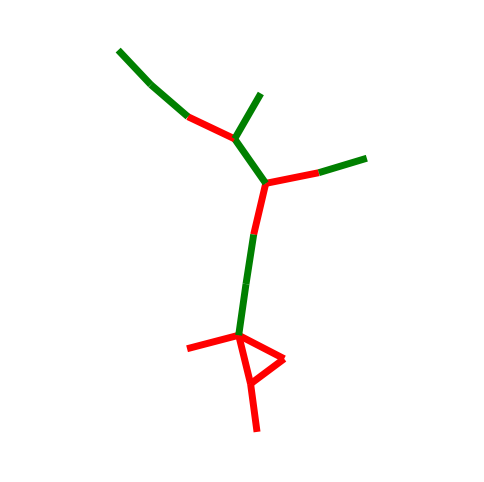

In [107]:
trainer[0].evaluate(threshold=0.5, show=True)

# Green Cyclic

In [79]:
classes = 1
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_edge_cls=len(dataset.EDGE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=False,
                                    learn_edge_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingCriterion(classes=[classes], beta=2), mode="maximize", weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=1),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    # NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    # NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    NormPenalty(lambda: s.eta, order=1, weight=0), # L1 penalty on eta
    NormPenalty(lambda: s.eta, order=2, weight=0), # L2 penalty on eta
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=1), # Budget penalty on theta, encourage sparsity
    # CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=1), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                  discriminator=model,
                  criterion=criterion,
                  optimizer=optimizer,
                  scheduler=scheduler,
                  dataset=dataset,
                  k_samples=16)

In [80]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9


In [81]:
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 15
    ])

In [82]:
trainer[1].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=14 m=13
logits=[2.3529834747314453, 22.390623092651367, 5.320788860321045]
probs=[1.9850145971389566e-09, 1.0, 3.860694164359302e-08]


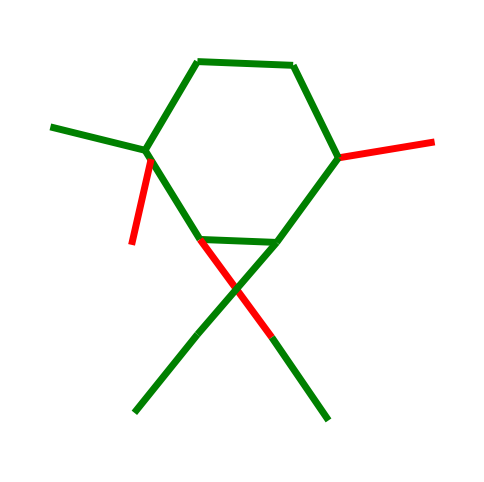

In [83]:
trainer[1].evaluate(threshold=0.5, show=True)

# Acyclic

In [93]:
classes = 2
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_edge_cls=len(dataset.EDGE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=False,
                                    learn_edge_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingCriterion(classes=[classes], beta=2), mode="maximize", weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=1),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    # NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    # NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    NormPenalty(lambda: s.eta, order=1, weight=0), # L1 penalty on eta
    NormPenalty(lambda: s.eta, order=2, weight=0), # L2 penalty on eta
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=1), # Budget penalty on theta, encourage sparsity
    # CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=1), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=dataset,
                           k_samples=16)

In [94]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9


In [95]:
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 15
    ])

In [96]:
trainer[2].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=16 m=15
logits=[-15.309328079223633, -23.493947982788086, -7.510899066925049]
probs=[0.000410210806876421, 1.1441201053230543e-07, 0.999589741230011]


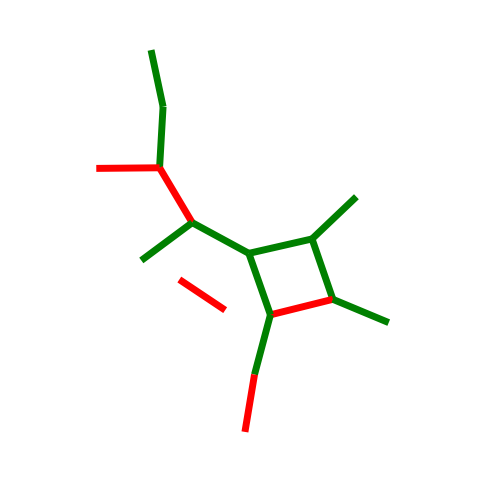

In [97]:
trainer[2].evaluate(threshold=0.5, show=True)